example: MA strategy says go long when price crosses moving average  

RF classifier determines probability of misclassification  

p[x] is probabilitiy that label x takes place  

x ∈ {−1, 1} i.e. take the bet or pass

In [99]:
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
from pathlib import PurePath, Path
import pyarrow
import scipy.stats as stats
import scipy
from statsmodels.tsa.stattools import adfuller
import time
import sys
import datetime


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC


from book_functions import *

importlib.reload(sys.modules['book_functions'])
# importlib.reload(sys.modules['sklearn'])

<module 'book_functions' from 'C:\\Users\\mlevy\\Workspace\\Advances-in-Financial-Machine-Learning\\F-ML\\book_functions.py'>

### 10.1

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


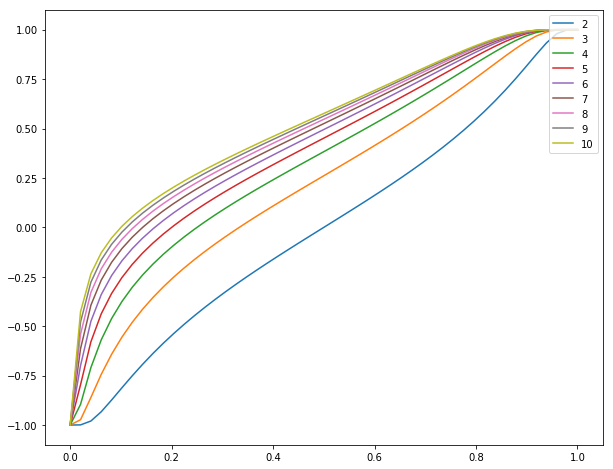

In [2]:
plt.figure(figsize=(10,8))
prob = np.linspace(0, 1)
pred = 1
for numClasses in range(2, 11):
    signal0 = (prob-1./numClasses)/(prob*(1.-prob))**.5  # t-value of OvR
    signal0 = pred*(2*stats.norm.cdf(signal0)-1)  # signal=side*size
    plt.plot(prob, signal0, label=numClasses)
    plt.legend(loc='upper right')

### 10.2

In [19]:
rand_nums = np.random.uniform(.5, 1., 10000)

In [20]:
rand_nums

array([0.87787785, 0.50363553, 0.96765985, ..., 0.89403702, 0.52083568,
       0.61940145])

In [21]:
# a
prob = rand_nums
pred = np.sign(np.random.uniform(-1, 1, 10000))  # random sides (1's and -1's)
numClasses = 2

signal0 = (prob-1./numClasses)/(prob*(1.-prob))**.5  # t-value of OvR
signal0 = pred*(2*stats.norm.cdf(signal0)-1)  # signal=side*size

bet_sizes = signal0

In [22]:
# b
dates = pd.DatetimeIndex(data=pd.date_range(
            end=pd.datetime.today(), periods=10000, freq='1D'))

In [23]:
dates

DatetimeIndex(['1992-01-05 18:23:23.579343', '1992-01-06 18:23:23.579343',
               '1992-01-07 18:23:23.579343', '1992-01-08 18:23:23.579343',
               '1992-01-09 18:23:23.579343', '1992-01-10 18:23:23.579343',
               '1992-01-11 18:23:23.579343', '1992-01-12 18:23:23.579343',
               '1992-01-13 18:23:23.579343', '1992-01-14 18:23:23.579343',
               ...
               '2019-05-13 18:23:23.579343', '2019-05-14 18:23:23.579343',
               '2019-05-15 18:23:23.579343', '2019-05-16 18:23:23.579343',
               '2019-05-17 18:23:23.579343', '2019-05-18 18:23:23.579343',
               '2019-05-19 18:23:23.579343', '2019-05-20 18:23:23.579343',
               '2019-05-21 18:23:23.579343', '2019-05-22 18:23:23.579343'],
              dtype='datetime64[ns]', length=10000, freq='D')

In [24]:
# c
shifts = np.random.uniform(1, 25, 10000)

In [25]:
# d
shifted_dates = []
for date, shift in zip(dates, shifts):
    shifted_dates.append(date + datetime.timedelta(days=shift))

In [26]:
# Similar to an end time when one of the barriers were touched
t1 = pd.Series(shifted_dates, index=dates)

In [27]:
# e
signals = t1.to_frame('t1')
signals['signal'] = bet_sizes

In [28]:
signals

,t1,signal
1992-01-05 18:23:23.579343,1992-01-19 16:08:30.823858,0.751534
1992-01-06 18:23:23.579343,1992-01-10 18:48:33.451979,-0.005802
1992-01-07 18:23:23.579343,1992-01-10 14:12:06.361116,-0.991797
1992-01-08 18:23:23.579343,1992-01-12 06:16:13.112556,-0.911997
1992-01-09 18:23:23.579343,1992-01-11 14:03:20.807999,-0.747713
1992-01-10 18:23:23.579343,1992-01-21 12:44:32.453008,-0.446028
1992-01-11 18:23:23.579343,1992-02-02 14:30:56.625949,0.740859
1992-01-12 18:23:23.579343,1992-02-02 00:24:00.483946,-0.999947
1992-01-13 18:23:23.579343,1992-01-16 22:41:08.760513,-1.000000
1992-01-14 18:23:23.579343,1992-01-21 11:08:56.032115,0.105547


In [29]:
avg_signals = avgActiveSignals(signals, 1)

In [30]:
avg_signals

1992-01-05 18:23:23.579343    0.751534
1992-01-06 18:23:23.579343    0.372866
1992-01-07 18:23:23.579343   -0.082022
1992-01-08 18:23:23.579343   -0.289516
1992-01-09 18:23:23.579343   -0.381155
1992-01-10 14:12:06.361116   -0.228495
1992-01-10 18:23:23.579343   -0.272001
1992-01-10 18:48:33.451979   -0.338551
1992-01-11 14:03:20.807999   -0.202164
1992-01-11 18:23:23.579343    0.033592
1992-01-12 06:16:13.112556    0.348788
1992-01-12 18:23:23.579343    0.011604
1992-01-13 18:23:23.579343   -0.190716
1992-01-14 18:23:23.579343   -0.141339
1992-01-15 18:23:23.579343   -0.058787
1992-01-16 18:23:23.579343   -0.080167
1992-01-16 22:41:08.760513    0.051238
1992-01-17 18:23:23.579343    0.169236
1992-01-18 18:23:23.579343    0.137716
1992-01-19 16:08:30.823858    0.060989
1992-01-19 18:23:23.579343    0.077391
1992-01-20 18:23:23.579343    0.050017
1992-01-20 23:17:59.660450    0.068290
1992-01-21 11:08:56.032115    0.063633
1992-01-21 12:44:32.453008    0.136442
1992-01-21 18:23:23.57934

### 10.3

In [3]:
def countActiveSignals(signals, molecule):
    #import pdb;pdb.set_trace()
    out = pd.DataFrame(columns=['cl', 'cs'])
    for loc in molecule:
        df0 = (signals.index.values <= loc) & (
            (loc < signals['t1']) | pd.isnull(signals['t1']))
        act = signals[df0].index
        if len(act) > 0:
            concurr_bets = signals.loc[act, 'signal']
            cl = sum(concurr_bets > 0)
            cs = sum(concurr_bets <= 0)
            out.loc[loc] = [cl, cs]
        else:
            out.loc[loc] = [0, 0]  # no signals active at this time
    return out

In [34]:
# mini example, TODO: use size 10,000
size = 100

rand_nums = np.random.uniform(.5, 1., size)
prob = rand_nums
pred = np.sign(np.random.uniform(-1, 1, size))  # random sides (1's and -1's)
numClasses = 2

signal0 = (prob-1./numClasses)/(prob*(1.-prob))**.5  # t-value of OvR
signal0 = pred*(2*stats.norm.cdf(signal0)-1)  # signal=side*size

bet_sizes = signal0


dates = pd.DatetimeIndex(data=pd.date_range(
            end=pd.datetime.today(), periods=size, freq='1D'))

shifts = np.random.uniform(1, 25, size)
shifted_dates = []
for date, shift in zip(dates, shifts):
    shifted_dates.append(date + datetime.timedelta(days=shift))
    
t1 = pd.Series(shifted_dates, index=dates)

signals = t1.to_frame('t1')
signals['signal'] = bet_sizes

avg_signals = avgActiveSignals(signals, 1)

tPnts = set(signals['t1'].dropna().values)
tPnts = tPnts.union(signals.index.values)
tPnts = list(tPnts)
tPnts.sort()

In [35]:
signals.head(20)

,t1,signal
2019-02-13 16:23:59.481648,2019-02-22 04:36:58.610516,-0.270466
2019-02-14 16:23:59.481648,2019-02-27 16:48:38.307279,-0.480819
2019-02-15 16:23:59.481648,2019-02-25 13:11:20.526514,-0.999425
2019-02-16 16:23:59.481648,2019-03-06 07:59:35.827472,0.561948
2019-02-17 16:23:59.481648,2019-02-21 02:23:48.699204,0.845126
2019-02-18 16:23:59.481648,2019-02-25 14:39:52.392821,-0.921022
2019-02-19 16:23:59.481648,2019-03-06 00:24:31.552399,-0.999992
2019-02-20 16:23:59.481648,2019-03-06 09:15:09.952930,-0.401534
2019-02-21 16:23:59.481648,2019-03-09 14:43:38.021004,-0.082653
2019-02-22 16:23:59.481648,2019-03-11 23:15:17.250710,-0.249373


In [36]:
cc = countActiveSignals(signals, tPnts)

In [37]:
cc

,cl,cs
2019-02-13 16:23:59.481648,0,1
2019-02-14 16:23:59.481648,0,2
2019-02-15 16:23:59.481648,0,3
2019-02-16 16:23:59.481648,1,3
2019-02-17 16:23:59.481648,2,3
2019-02-18 16:23:59.481648,2,4
2019-02-19 16:23:59.481648,2,5
2019-02-20 16:23:59.481648,2,6
2019-02-21 02:23:48.699204,1,6
2019-02-21 16:23:59.481648,1,7


In [38]:
# 3 a, b
cl_max = cc.cl.max()
cs_max = cc.cs.max()

In [39]:
# 3c
cc['m'] = cc.cl*(1/cl_max) - cc.cs*(1/cs_max)

In [40]:
cc

,cl,cs,m
2019-02-13 16:23:59.481648,0,1,-0.1
2019-02-14 16:23:59.481648,0,2,-0.2
2019-02-15 16:23:59.481648,0,3,-0.3
2019-02-16 16:23:59.481648,1,3,-0.2
2019-02-17 16:23:59.481648,2,3,-0.1
2019-02-18 16:23:59.481648,2,4,-0.2
2019-02-19 16:23:59.481648,2,5,-0.3
2019-02-20 16:23:59.481648,2,6,-0.4
2019-02-21 02:23:48.699204,1,6,-0.5
2019-02-21 16:23:59.481648,1,7,-0.6


### 10.4

In [42]:
cc['c'] = cc.cl - cc.cs

In [43]:
cc

,cl,cs,m,c
2019-02-13 16:23:59.481648,0,1,-0.1,-1
2019-02-14 16:23:59.481648,0,2,-0.2,-2
2019-02-15 16:23:59.481648,0,3,-0.3,-3
2019-02-16 16:23:59.481648,1,3,-0.2,-2
2019-02-17 16:23:59.481648,2,3,-0.1,-1
2019-02-18 16:23:59.481648,2,4,-0.2,-2
2019-02-19 16:23:59.481648,2,5,-0.3,-3
2019-02-20 16:23:59.481648,2,6,-0.4,-4
2019-02-21 02:23:48.699204,1,6,-0.5,-5
2019-02-21 16:23:59.481648,1,7,-0.6,-6


In [45]:
# b
from sklearn.mixture import GaussianMixture

In [52]:
gmm = GaussianMixture(n_components=2, random_state=123, verbose=1)
gmm.fit(cc['c'].values.reshape(-1, 1))

Initialization 0
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=123, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [47]:
# c
# TODO: Figure out how to do CDF of fitted gmm
# d
# compare with 10.3

AttributeError: 'GaussianMixture' object has no attribute 'cdf'

### 10.5

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


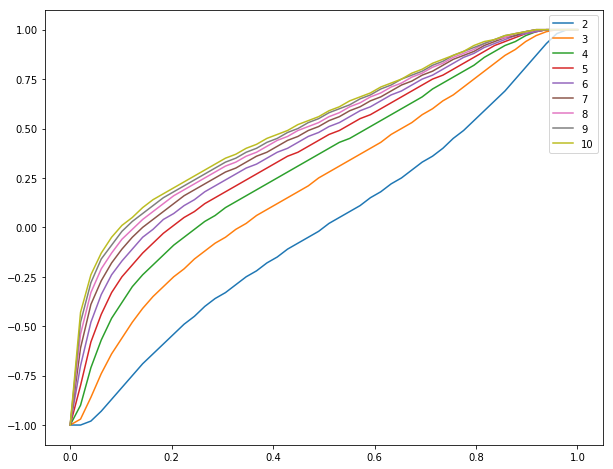

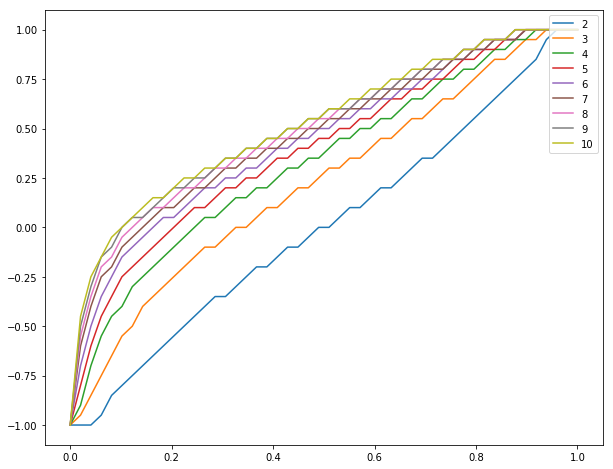

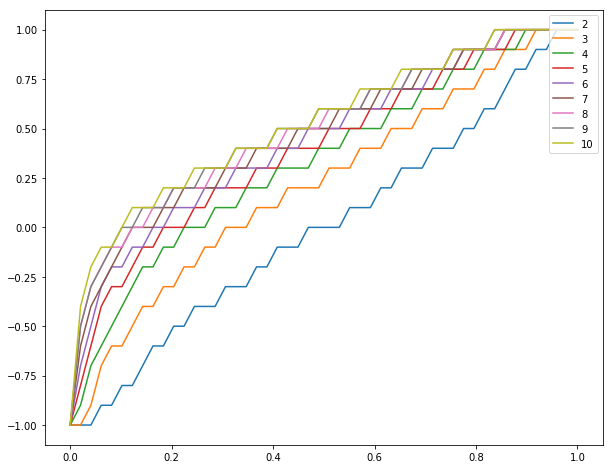

In [55]:
stepSizes = [.01, .05, .1]
for stepSize in stepSizes:
    plt.figure(figsize=(10,8))
    prob = np.linspace(0, 1)
    pred = 1
    for numClasses in range(2, 11):
        signal0 = (prob-1./numClasses)/(prob*(1.-prob))**.5  # t-value of OvR
        signal0 = pred*(2*stats.norm.cdf(signal0)-1)  # signal=side*size
        signal1 = discreteSignal(signal0, stepSize=stepSize)
        plt.plot(prob, signal1, label=numClasses)
        plt.legend(loc='upper right')

### 10.6

In [102]:
# TODO: verify that sgn[x] is same as sign(x)
# pg.147
def betSizePower(w, x):
    # x has to be b/w [-1, 1]
    # can't use f-mP like we did for sigmoid
    return np.sign(x)*abs(x)**w

def getTPosPower(w, f, mP, maxPos):
    return int(betSizePower(w, f-mP)*maxPos)

### 10.7

In [104]:
# Sigmoid version
pos, maxPos, mP, f, wParams = 0, 100, 100, 115, {'divergence': 10, 'm': .95}
w = getW(wParams['divergence'], wParams['m'])  # calibrate w
tPos = getTPos(w, f, mP, maxPos)  # get tPos
lP = limitPrice(tPos, pos, f, w, maxPos)  # limit price for order
print(lP, tPos)

112.36573855883363 97


In [103]:
# Power version
pos, maxPos, mP, f, wParams = 0, 100, 100, 115, {'divergence': 10, 'm': .95}
w = getW(wParams['divergence'], wParams['m'])  # calibrate w
tPos = getTPosPower(w, f, mP, maxPos)  # get tPos
print(tPos)
lP = limitPrice(tPos, pos, f, w, maxPos)  # limit price for order
print(lP, tPos)

TypeError: unsupported operand type(s) for /: 'int' and 'module'

In [ ]:
# TODO: redo 10.6, 10.7 (both are wrong)
# suppose to rewrite equations and then in 10.7
# rewrite python code.
# need to understand what sigmoid is accomplishing and
# do the same with power function.